In [ ]:
import os
import numpy as np
import torch
from torch import nn
import my_nntools as nt
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import itertools
import time
import models as models
from utils import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [107]:
dataset_root_dir="./test_images/"

In [108]:
test_set = ImageDataset(dataset_root_dir, image_size=256, unaligned=False, mode='test')
train_set = [0]

In [109]:
class C_GAN(NNClassifier):
    def __init__(self, fine_tuning=True):
        super(C_GAN, self).__init__()
        
        self.G_A2B = models.Generator(3, 3)
        self.G_B2A = models.Generator(3, 3)
        self.D_A = models.Discriminator(3)
        self.D_B = models.Discriminator(3)
        
        self.G_A2B.apply(init_parameters)
        self.G_A2B.apply(init_parameters)
        self.D_A.apply(init_parameters)
        self.D_B.apply(init_parameters)
    
        self.fake_a_buffer = ReplayBuffer()
        self.fake_b_buffer = ReplayBuffer()
    
    def forward(self, real_a, real_b):        
        fake_b = self.G_A2B(real_a)
        fake_a = self.G_B2A(real_b)
        return fake_a,fake_b

In [110]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h



In [133]:
def eval_net(net,test_loader):
    net.eval()
    
    with torch.no_grad():
        
        real_a,real_b = next(iter(test_loader))
        real_a, real_b = real_a.to(net.device), real_b.to(net.device)
        fake_a,fake_b = net(real_a, real_b)
        a2b2a,b2a2b  = net(fake_a,fake_b)
    return fake_a, real_b


In [ ]:
optimizer_G = torch.optim.Adam(itertools.chain(net.G_A2B.parameters(), 
                                               net.G_B2A.parameters()), lr=lr)
optimizer_D_A = torch.optim.Adam(net.D_A.parameters(), lr=lr)
optimizer_D_B = torch.optim.Adam(net.D_B.parameters(), lr=lr)

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(200, 0, 100).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(200, 0, 100).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(200, 0, 100).step)

lr_scheduler = [lr_scheduler_G, lr_scheduler_D_A,lr_scheduler_D_B]
stats_manager = ClassificationStatsManager()



In [142]:
net_van_gogh = C_GAN()
net_van_gogh = net_van_gogh.to(device)
exp1 = nt.Experiment(net_van_gogh, train_set, test_set, 
                     optimizer_G, optimizer_D_A,optimizer_D_B,lr_scheduler,stats_manager, output_dir="./model_weights/Van_gogh",batch_size=4)


In [143]:
net_ukiyo = C_GAN()
net_ukiyo = net_ukiyo.to(device)
exp2 = nt.Experiment(net_ukiyo, train_set, test_set, 
                     optimizer_G, optimizer_D_A,optimizer_D_B,lr_scheduler,stats_manager, output_dir="./model_weights/Ukiyo",batch_size=4)

In [144]:
net_cezanne = C_GAN()
net_cezanne = net_cezanne.to(device)
exp3 = nt.Experiment(net_cezanne, train_set, test_set, 
                     optimizer_G, optimizer_D_A,optimizer_D_B,lr_scheduler,stats_manager, output_dir="./model_weights/Cezanne",batch_size=4)

In [145]:
test_loader = td.DataLoader(test_set, batch_size=4, shuffle=False, drop_last=False, pin_memory=True)

In [146]:
output_vangogh = eval_net(net_van_gogh,test_loader)
output_cezanne = eval_net(net_cezanne,test_loader)
output_ukiyo = eval_net(net_ukiyo,test_loader)

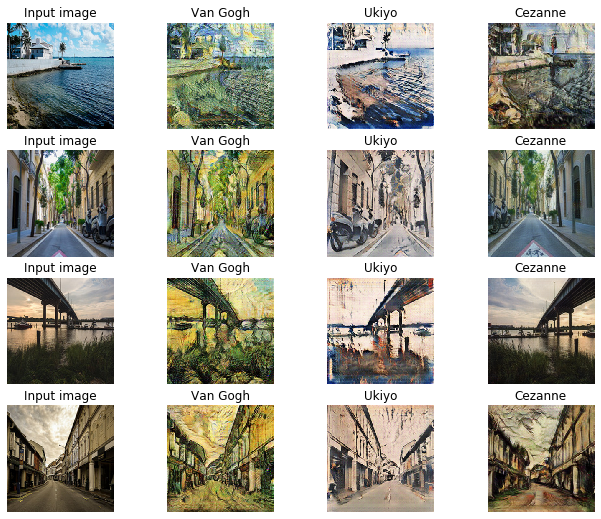

In [149]:
fig, axs = plt.subplots(4,4, figsize=(11,9),sharex=True, sharey=True)

for i in range(4):
    myimshow(output_vangogh[1][i],ax =axs[i,0] )
    myimshow(output_vangogh[0][i],ax = axs[i,1])
    myimshow(output_cezanne[0][i],ax = axs[i,3])
    myimshow(output_ukiyo[0][i],ax = axs[i,2])
    axs[i,0].set_title('Input image')
    axs[i,1].set_title('Van Gogh')
    axs[i,2].set_title('Ukiyo')
    axs[i,3].set_title('Cezanne')